In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from haversine import haversine
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import LearningCurveDisplay

In [2]:
from google.cloud import bigquery

In [3]:
client = bigquery.Client()

In [4]:

query = """ SELECT * FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE pickup_latitude IS NOT NULL
AND pickup_longitude IS NOT NULL
AND dropoff_latitude IS NOT NULL
AND dropoff_longitude IS NOT NULL
AND trip_miles IS NOT NULL
LIMIT 20000
"""

In [5]:
df = client.query(query).result().to_dataframe()
df

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,b8450a1ac9730954221c2c05bc497ab158712efc,cd4f6f56e92648beaffe3d840688cf7667fa10fa30dfb1...,2016-12-20 13:15:00+00:00,2016-12-20 13:30:00+00:00,841,2.7,<NA>,<NA>,21,23,...,0.0,10.75,Cash,Yellow Cab,41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),41.900070,-87.720918,POINT (-87.7209182385 41.9000696026)
1,68f20a44f32ecef5ebd68515f71aaeab3c2b99d8,b7a173e9444bf6c1d208274e90ce497f3a959a070d7a31...,2016-12-30 10:45:00+00:00,2016-12-30 11:00:00+00:00,725,1.8,<NA>,<NA>,19,15,...,1.0,10.00,Cash,Yellow Cab,41.927261,-87.765502,POINT (-87.7655016086 41.9272609555),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487)
2,93602349bbdfd3e91aa86368bb703085cdaa2acb,9dcfa7d3af9263f9021b4ca61c44896409f27e7d59245f...,2016-12-17 22:45:00+00:00,2016-12-17 22:45:00+00:00,559,1.5,17031070300,17031832000,7,6,...,2.0,9.00,Cash,Yellow Cab,41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),41.946295,-87.654298,POINT (-87.6542980837 41.9462945357)
3,809e87bb58b3a7f21a020558947ab1eb50d61fc2,30ae9a5f9f6b7aa8aa4fb6637657f3041bfd2059d0d183...,2016-12-16 17:30:00+00:00,2016-12-16 18:00:00+00:00,1596,5.4,<NA>,<NA>,61,28,...,0.0,19.00,Cash,Yellow Cab,41.809018,-87.659167,POINT (-87.6591665992 41.8090182499),41.874005,-87.663518,POINT (-87.6635175498 41.874005383)
4,ea0488bd6e459404ffd5c2619b2166da38de4b4a,e6019cfee940d876a99115822ce2c49167ae9214a083af...,2016-12-15 09:00:00+00:00,2016-12-15 09:00:00+00:00,465,0.2,17031839000,17031839100,32,32,...,0.0,5.75,Cash,Yellow Cab,41.871016,-87.631407,POINT (-87.6314065252 41.8710158803),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,79023b7c915aa7254b10d9439fa3716726eaa6f7,60e9b32a85d0045d670d329891f51b9796543659769e9a...,2016-10-10 03:00:00+00:00,2016-10-10 03:15:00+00:00,361,1.5,<NA>,<NA>,22,22,...,0.0,7.00,Cash,Checker Taxi,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205)
19996,28007fe198ff619ca0dafd92d6aadcceea372a5b,48b43342788ae1b9b57a4e36cf85b8555d0cae1ec42ce2...,2016-10-17 09:30:00+00:00,2016-10-17 09:45:00+00:00,1447,6.6,<NA>,<NA>,22,8,...,1.0,25.63,Credit Card,Checker Taxi,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
19997,992dbc71024f186e3b4462d8de7b1a9eaed7c77d,0423b61dd9d4f4da3f4490e3dfed085a321aa78d527286...,2016-10-10 18:30:00+00:00,2016-10-10 18:30:00+00:00,19,0.0,<NA>,<NA>,22,22,...,0.0,3.25,Cash,Checker Taxi,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205)
19998,12fb231640e3842c9fd26ab9ddca4e22da144f99,d3e38cf4471f5b65aa0c41a155252c395b7c8593ac6fb5...,2016-10-15 02:30:00+00:00,2016-10-15 02:30:00+00:00,717,3.4,<NA>,<NA>,22,7,...,0.0,14.09,Credit Card,Checker Taxi,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843)


In [6]:
df.shape

(20000, 23)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   unique_key              20000 non-null  object             
 1   taxi_id                 20000 non-null  object             
 2   trip_start_timestamp    20000 non-null  datetime64[ns, UTC]
 3   trip_end_timestamp      20000 non-null  datetime64[ns, UTC]
 4   trip_seconds            20000 non-null  Int64              
 5   trip_miles              20000 non-null  float64            
 6   pickup_census_tract     14849 non-null  Int64              
 7   dropoff_census_tract    14849 non-null  Int64              
 8   pickup_community_area   19998 non-null  Int64              
 9   dropoff_community_area  19970 non-null  Int64              
 10  fare                    20000 non-null  float64            
 11  tips                    20000 non-null  f

In [8]:
# Convert the datetime column to datetime dtype
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])

# Convert datetime values to the desired format
df['trip_start_timestamp'] = df['trip_start_timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [9]:
df.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,b8450a1ac9730954221c2c05bc497ab158712efc,cd4f6f56e92648beaffe3d840688cf7667fa10fa30dfb1...,2016-12-20 13:15:00,2016-12-20 13:30:00+00:00,841,2.7,<NA>,<NA>,21,23,...,0.0,10.75,Cash,Yellow Cab,41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),41.900070,-87.720918,POINT (-87.7209182385 41.9000696026)
1,68f20a44f32ecef5ebd68515f71aaeab3c2b99d8,b7a173e9444bf6c1d208274e90ce497f3a959a070d7a31...,2016-12-30 10:45:00,2016-12-30 11:00:00+00:00,725,1.8,<NA>,<NA>,19,15,...,1.0,10.00,Cash,Yellow Cab,41.927261,-87.765502,POINT (-87.7655016086 41.9272609555),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487)
2,93602349bbdfd3e91aa86368bb703085cdaa2acb,9dcfa7d3af9263f9021b4ca61c44896409f27e7d59245f...,2016-12-17 22:45:00,2016-12-17 22:45:00+00:00,559,1.5,17031070300,17031832000,7,6,...,2.0,9.00,Cash,Yellow Cab,41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),41.946295,-87.654298,POINT (-87.6542980837 41.9462945357)
3,809e87bb58b3a7f21a020558947ab1eb50d61fc2,30ae9a5f9f6b7aa8aa4fb6637657f3041bfd2059d0d183...,2016-12-16 17:30:00,2016-12-16 18:00:00+00:00,1596,5.4,<NA>,<NA>,61,28,...,0.0,19.00,Cash,Yellow Cab,41.809018,-87.659167,POINT (-87.6591665992 41.8090182499),41.874005,-87.663518,POINT (-87.6635175498 41.874005383)
4,ea0488bd6e459404ffd5c2619b2166da38de4b4a,e6019cfee940d876a99115822ce2c49167ae9214a083af...,2016-12-15 09:00:00,2016-12-15 09:00:00+00:00,465,0.2,17031839000,17031839100,32,32,...,0.0,5.75,Cash,Yellow Cab,41.871016,-87.631407,POINT (-87.6314065252 41.8710158803),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)


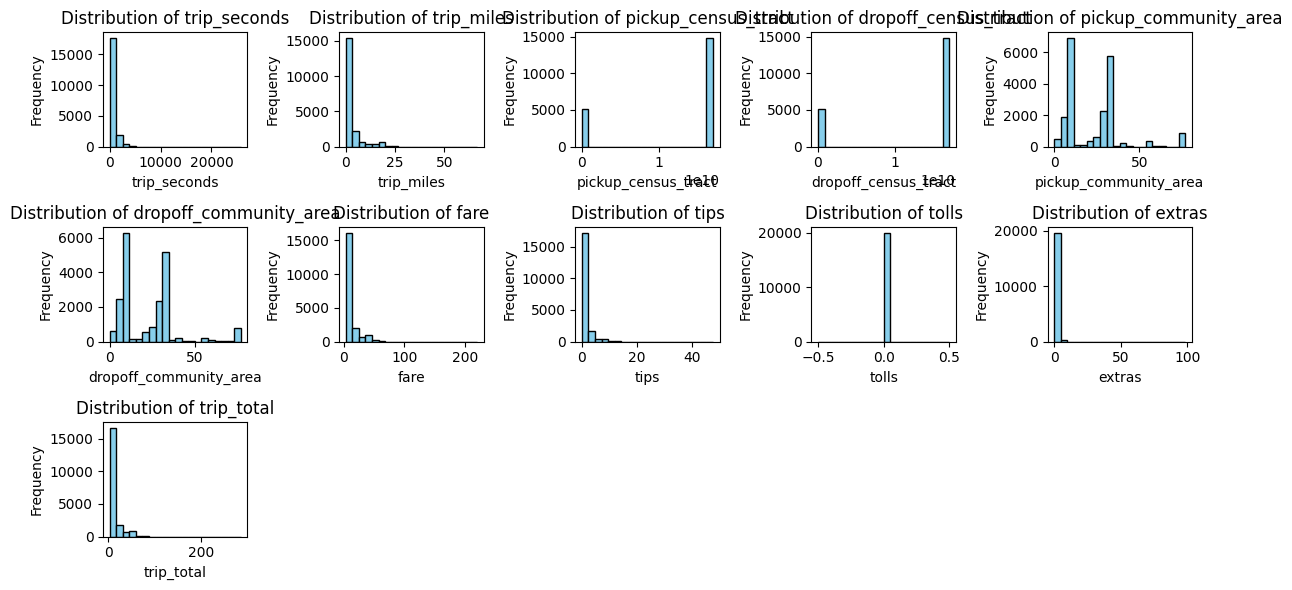

In [10]:
test_df = df
test_df.fillna(0, inplace=True)

features = ['trip_seconds', 'trip_miles', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area', 'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras', 'trip_total']

num_features = len(features)
num_cols = 5
num_rows = (num_features - 1) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i, feature in enumerate(features):
    row_index = i // num_cols
    col_index = i % num_cols

    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]

    ax.hist(df[feature], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Remove any empty subplots
for i in range(num_features, num_rows * num_cols):
    row_index = i // num_cols
    col_index = i % num_cols
    fig.delaxes(axes[row_index, col_index])

plt.tight_layout()
plt.show()

In [11]:
to_drop = ["taxi_id",
           "pickup_census_tract",
           "dropoff_census_tract",
           "tips",
           "trip_seconds",
           "trip_miles",
           "extras",
           "trip_total",
           "company",
           "tolls",
           "payment_type",
           "trip_end_timestamp"]

# Drop selected fields in place
df.drop(to_drop, inplace=True, axis=1)

In [12]:
df.head()

,unique_key,trip_start_timestamp,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,b8450a1ac9730954221c2c05bc497ab158712efc,2016-12-20 13:15:00,21,23,10.75,41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),41.900070,-87.720918,POINT (-87.7209182385 41.9000696026)
1,68f20a44f32ecef5ebd68515f71aaeab3c2b99d8,2016-12-30 10:45:00,19,15,9.00,41.927261,-87.765502,POINT (-87.7655016086 41.9272609555),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487)
2,93602349bbdfd3e91aa86368bb703085cdaa2acb,2016-12-17 22:45:00,7,6,7.00,41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),41.946295,-87.654298,POINT (-87.6542980837 41.9462945357)
3,809e87bb58b3a7f21a020558947ab1eb50d61fc2,2016-12-16 17:30:00,61,28,19.00,41.809018,-87.659167,POINT (-87.6591665992 41.8090182499),41.874005,-87.663518,POINT (-87.6635175498 41.874005383)
4,ea0488bd6e459404ffd5c2619b2166da38de4b4a,2016-12-15 09:00:00,32,32,5.75,41.871016,-87.631407,POINT (-87.6314065252 41.8710158803),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   unique_key              20000 non-null  object 
 1   trip_start_timestamp    20000 non-null  object 
 2   pickup_community_area   20000 non-null  Int64  
 3   dropoff_community_area  20000 non-null  Int64  
 4   fare                    20000 non-null  float64
 5   pickup_latitude         20000 non-null  float64
 6   pickup_longitude        20000 non-null  float64
 7   pickup_location         20000 non-null  object 
 8   dropoff_latitude        20000 non-null  float64
 9   dropoff_longitude       20000 non-null  float64
 10  dropoff_location        20000 non-null  object 
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.7+ MB


In [14]:
df.drop(columns=['unique_key'], inplace=True, axis=1)
df.head()

,trip_start_timestamp,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,2016-12-20 13:15:00,21,23,10.75,41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),41.900070,-87.720918,POINT (-87.7209182385 41.9000696026)
1,2016-12-30 10:45:00,19,15,9.00,41.927261,-87.765502,POINT (-87.7655016086 41.9272609555),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487)
2,2016-12-17 22:45:00,7,6,7.00,41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),41.946295,-87.654298,POINT (-87.6542980837 41.9462945357)
3,2016-12-16 17:30:00,61,28,19.00,41.809018,-87.659167,POINT (-87.6591665992 41.8090182499),41.874005,-87.663518,POINT (-87.6635175498 41.874005383)
4,2016-12-15 09:00:00,32,32,5.75,41.871016,-87.631407,POINT (-87.6314065252 41.8710158803),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)


In [15]:
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
df['weekday'] = df['trip_start_timestamp'].map(lambda x: x.weekday())
df['time'] = df['trip_start_timestamp'].map(lambda x: x.hour*4 + round(x.minute/15))

df.head()

,trip_start_timestamp,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,weekday,time
0,2016-12-20 13:15:00,21,23,10.75,41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),41.900070,-87.720918,POINT (-87.7209182385 41.9000696026),1,53
1,2016-12-30 10:45:00,19,15,9.00,41.927261,-87.765502,POINT (-87.7655016086 41.9272609555),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487),4,43
2,2016-12-17 22:45:00,7,6,7.00,41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),41.946295,-87.654298,POINT (-87.6542980837 41.9462945357),5,91
3,2016-12-16 17:30:00,61,28,19.00,41.809018,-87.659167,POINT (-87.6591665992 41.8090182499),41.874005,-87.663518,POINT (-87.6635175498 41.874005383),4,70
4,2016-12-15 09:00:00,32,32,5.75,41.871016,-87.631407,POINT (-87.6314065252 41.8710158803),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),3,36


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trip_start_timestamp    20000 non-null  datetime64[ns]
 1   pickup_community_area   20000 non-null  Int64         
 2   dropoff_community_area  20000 non-null  Int64         
 3   fare                    20000 non-null  float64       
 4   pickup_latitude         20000 non-null  float64       
 5   pickup_longitude        20000 non-null  float64       
 6   pickup_location         20000 non-null  object        
 7   dropoff_latitude        20000 non-null  float64       
 8   dropoff_longitude       20000 non-null  float64       
 9   dropoff_location        20000 non-null  object        
 10  weekday                 20000 non-null  int64         
 11  time                    20000 non-null  int64         
dtypes: Int64(2), datetime64[ns](1), float64(5), in

In [17]:
df

,trip_start_timestamp,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,weekday,time
0,2016-12-20 13:15:00,21,23,10.75,41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),41.900070,-87.720918,POINT (-87.7209182385 41.9000696026),1,53
1,2016-12-30 10:45:00,19,15,9.00,41.927261,-87.765502,POINT (-87.7655016086 41.9272609555),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487),4,43
2,2016-12-17 22:45:00,7,6,7.00,41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),41.946295,-87.654298,POINT (-87.6542980837 41.9462945357),5,91
3,2016-12-16 17:30:00,61,28,19.00,41.809018,-87.659167,POINT (-87.6591665992 41.8090182499),41.874005,-87.663518,POINT (-87.6635175498 41.874005383),4,70
4,2016-12-15 09:00:00,32,32,5.75,41.871016,-87.631407,POINT (-87.6314065252 41.8710158803),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),3,36
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2016-10-10 03:00:00,22,22,7.00,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),0,12
19996,2016-10-17 09:30:00,22,8,19.50,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),0,38
19997,2016-10-10 18:30:00,22,22,3.25,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),0,74
19998,2016-10-15 02:30:00,22,7,12.25,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),5,10


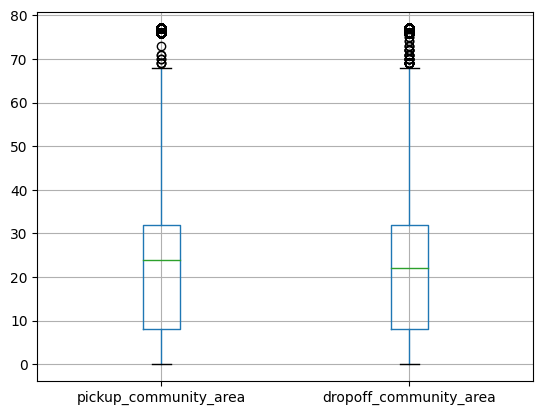

In [18]:
boxplot = df.boxplot(column=['pickup_community_area','dropoff_community_area'])

In [19]:
df.dropna(inplace=True)
df.shape

(20000, 12)

In [20]:
# Calculate the median
median_pickup = df['pickup_community_area'].median()
median_dropoff = df['dropoff_community_area'].median()

In [21]:
# Winsorization for pickup_community_area
data_pickup = df['pickup_community_area']
lower_limit_pickup = np.percentile(data_pickup, 5)  
upper_limit_pickup = np.percentile(data_pickup, 90)  

df['pickup_community_area'] = np.where((data_pickup < lower_limit_pickup) | (data_pickup > upper_limit_pickup), median_pickup, data_pickup)

# Updated boxplot with outliers replaced by median
# updated_boxplot = df.boxplot(column=['pickup_community_area', 'dropoff_community_area'])

In [22]:
# Winsorization for dropoff_community_area
data_dropoff = df['dropoff_community_area']
lower_limit_dropoff = np.percentile(data_dropoff, 5)  
upper_limit_dropoff = np.percentile(data_dropoff, 90)  

df['dropoff_community_area'] = np.where((data_dropoff < lower_limit_dropoff) | (data_dropoff > upper_limit_dropoff), median_dropoff, data_dropoff)

# Updated boxplot with outliers replaced by median
# updated_boxplot = df.boxplot(column=['pickup_community_area', 'dropoff_community_area'])

In [23]:
def calculate_distance(row):
    return haversine((row['pickup_latitude'], row['pickup_longitude']),
                      (row['dropoff_latitude'], row['dropoff_longitude']),
                      unit='m')

# Generate lineal distance field
df['distance'] = df.apply(calculate_distance, axis=1)

In [24]:
df.head()

,trip_start_timestamp,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,weekday,time,distance
0,2016-12-20 13:15:00,21,23,10.75,41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),41.900070,-87.720918,POINT (-87.7209182385 41.9000696026),1,53,4366.263308
1,2016-12-30 10:45:00,19,15,9.00,41.927261,-87.765502,POINT (-87.7655016086 41.9272609555),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487),4,43,2981.400916
2,2016-12-17 22:45:00,7,6,7.00,41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),41.946295,-87.654298,POINT (-87.6542980837 41.9462945357),5,91,1933.699396
3,2016-12-16 17:30:00,24.0,28,19.00,41.809018,-87.659167,POINT (-87.6591665992 41.8090182499),41.874005,-87.663518,POINT (-87.6635175498 41.874005383),4,70,7235.232663
4,2016-12-15 09:00:00,32,32,5.75,41.871016,-87.631407,POINT (-87.6314065252 41.8710158803),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),3,36,1115.102797


In [25]:
df.drop(columns=(['pickup_location', 'dropoff_location']), inplace=True, axis=1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trip_start_timestamp    20000 non-null  datetime64[ns]
 1   pickup_community_area   20000 non-null  object        
 2   dropoff_community_area  20000 non-null  object        
 3   fare                    20000 non-null  float64       
 4   pickup_latitude         20000 non-null  float64       
 5   pickup_longitude        20000 non-null  float64       
 6   dropoff_latitude        20000 non-null  float64       
 7   dropoff_longitude       20000 non-null  float64       
 8   weekday                 20000 non-null  int64         
 9   time                    20000 non-null  int64         
 10  distance                20000 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(2)
memory usage: 1.7+ MB


In [27]:
df.drop(columns=(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']), inplace=True, axis=1)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trip_start_timestamp    20000 non-null  datetime64[ns]
 1   pickup_community_area   20000 non-null  object        
 2   dropoff_community_area  20000 non-null  object        
 3   fare                    20000 non-null  float64       
 4   weekday                 20000 non-null  int64         
 5   time                    20000 non-null  int64         
 6   distance                20000 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 1.1+ MB


In [29]:
df.drop('trip_start_timestamp', inplace=True, axis=1)
df['pickup_community_area'] = df['pickup_community_area'].astype(int)
df['dropoff_community_area'] = df['dropoff_community_area'].astype(int)
X = df.drop('fare', axis=1)
y = df['fare']
y = np.asarray(y, dtype=np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [30]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

In [31]:
y_pred_lr = lr.predict(X_test).flatten()

In [32]:
df_test_lr = pd.DataFrame(data={"Actual test":y_test, "Prediction":y_pred_lr})
df_test_lr

,Actual test,Prediction
0,10.50,11.732879
1,6.75,6.668775
2,9.75,8.396793
3,7.00,7.605418
4,6.75,6.384045
...,...,...
3995,3.25,5.063701
3996,9.75,10.490616
3997,13.00,8.491056
3998,4.75,5.002847


In [33]:
mse = mean_squared_error(y_pred_lr, y_test)
rmse = root_mean_squared_error(y_pred_lr, y_test)
mae = mean_absolute_error(y_pred_lr, y_test)
mape = mean_absolute_percentage_error(y_pred_lr, y_test)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MSE: 9.084908461600365
RMSE: 3.0141181897198996
MAE: 1.7592954656146125
MAPE: 0.19729531625508087


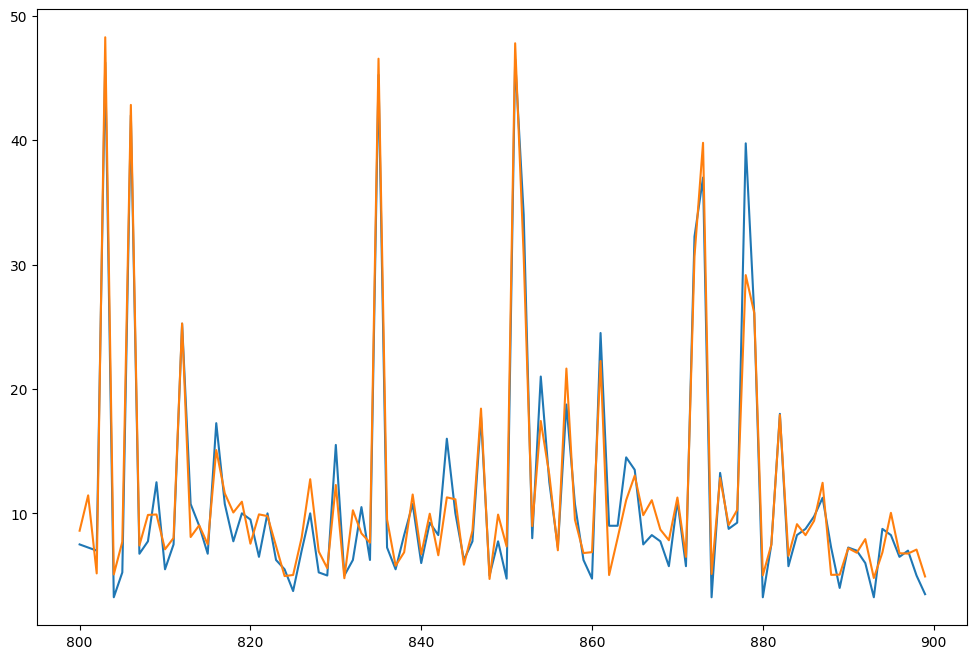

In [34]:
plt.figure(figsize=(12,8))
plt.plot(df_test_lr['Actual test'][800:900], label="A. Test")
plt.plot(df_test_lr['Prediction'][800:900], label="prediction")
plt.show()

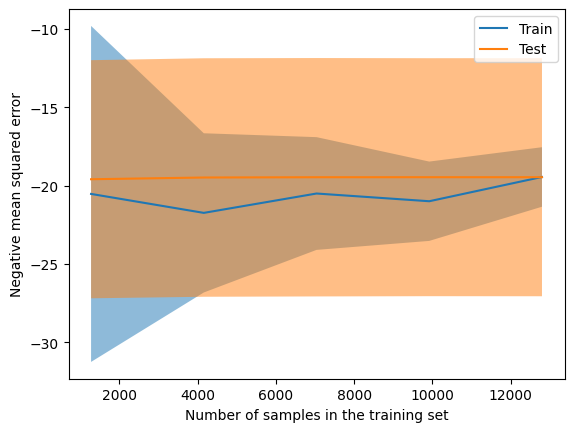

In [35]:
LearningCurveDisplay.from_estimator(lr, X_train, y_train, scoring = 'neg_mean_squared_error')
plt.show()

In [36]:
from sklearn.model_selection import GridSearchCV
import joblib

# Define the parameter grid
param_grid_lr = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1]
}

# Initialize Linear Regression and GridSearchCV
lr_model = GridSearchCV(LinearRegression(), param_grid=param_grid_lr, scoring='neg_mean_squared_error', cv=None, verbose=1, n_jobs=-1)

# Fit the model in parallel using all available CPU cores
with joblib.parallel_backend('threading', n_jobs=-1):
    lr_model.fit(X_train, y_train)

# Get the best parameters and initialize the tuned Linear Regression model
best_params = lr_model.best_params_
lr_model_tuned = LinearRegression(**best_params)

# Fit the tuned model
lr_model_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


LinearRegression(n_jobs=-1)

In [37]:
lr_model_tuned_pred = lr_model_tuned.predict(X_test)
mse_tuned = mean_squared_error(lr_model_tuned_pred, y_test)
rmse_tuned = root_mean_squared_error(lr_model_tuned_pred, y_test)
mae_tuned = mean_absolute_error(lr_model_tuned_pred, y_test)
mape_tuned = mean_absolute_percentage_error(lr_model_tuned_pred, y_test)


print(f'MSE: {mse_tuned}')
print(f'RMSE: {rmse_tuned}')
print(f'MAE: {mae_tuned}')
print(f'MAPE: {mape_tuned}')

MSE: 9.084908461600365
RMSE: 3.0141181897198996
MAE: 1.7592954656146125
MAPE: 0.19729531625508087


In [38]:
df_test_tuned_lr = pd.DataFrame(data={"Actual test":y_test, "Prediction":lr_model_tuned_pred})
df_test_tuned_lr

,Actual test,Prediction
0,10.50,11.732879
1,6.75,6.668775
2,9.75,8.396793
3,7.00,7.605418
4,6.75,6.384045
...,...,...
3995,3.25,5.063701
3996,9.75,10.490616
3997,13.00,8.491056
3998,4.75,5.002847


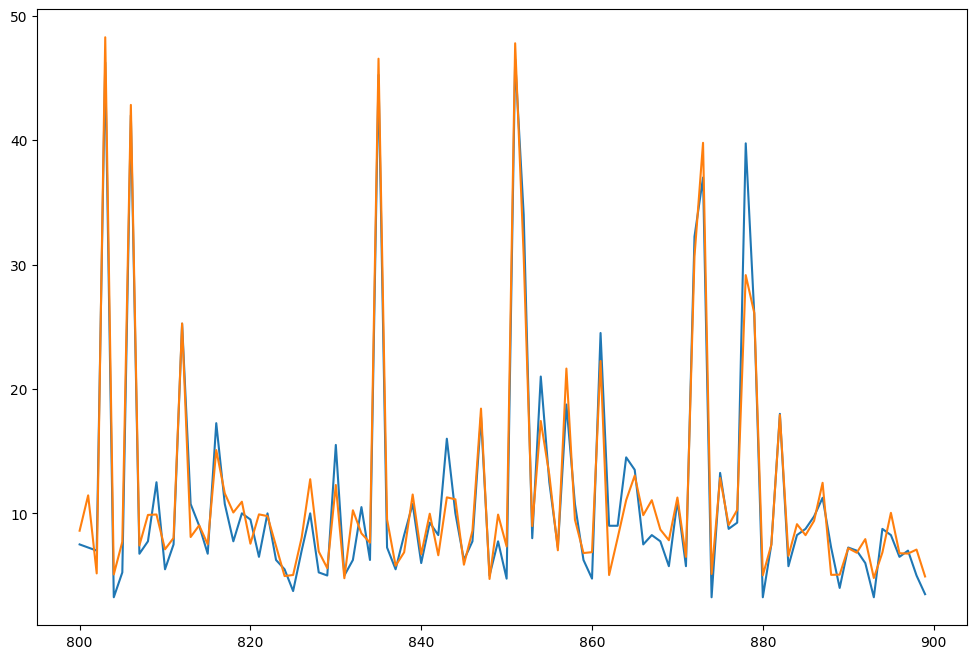

In [39]:
plt.figure(figsize=(12,8))
plt.plot(df_test_tuned_lr['Actual test'][800:900], label="A. Test")
plt.plot(df_test_tuned_lr['Prediction'][800:900], label="prediction")
plt.show()

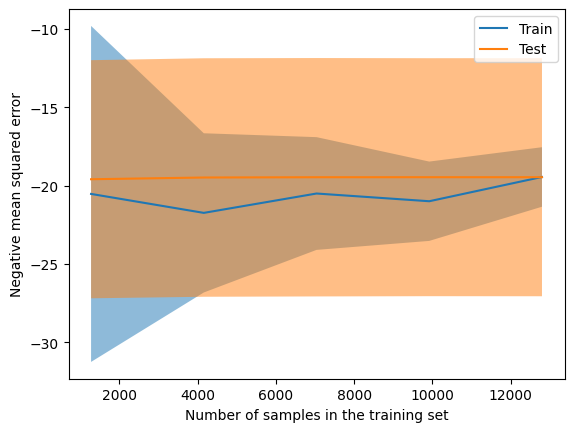

In [40]:
LearningCurveDisplay.from_estimator(lr_model_tuned, X_train, y_train, scoring = 'neg_mean_squared_error')
plt.show()